# City Showdown: How do Cambridge Cyclers Compare to Seattle Cyclers? 

This IPython Notebook follows the format of Jake VanderPlas's post on reproducible research and Seattle cyclers crossing the Fremont Bridge: https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/

Cycling is a popular way of commuting in Cambridge. It has even been said that Cambridge is a "[model cycling city](http://www.theguardian.com/environment/bike-blog/2011/aug/17/cambridge-model-cycling-city/)" due to its large student population, bike routes/parking, and amicable relationship between cyclists and drivers. 

Provided Jake's analysis on the behavior of Seattle cyclists and their sensitivity to factors such as daylight, temperature, and precipication, I conduct a similar analysis on Cambridge cyclists. By comparing the two cities, we can find out answers to the following questions: ** Are Seattlites really less afraid of the rain? Are Cantabrigians (yes, this is the actual term) more likely to bike in the cold?**

## The Data 

This post will use two datasets, which you can easily access with an internet connection. You can find the exact data I used in the [GitHub repository](https://github.com/lindabli/CambridgeBike), or access it from the original sources below.

First, I'll be using the City of Cambridge's Hampshire Street at Cardinal Medeiros Avenue vehicle and bike counts data. Data is provided at quarter hourly (15-minute) intervals. To download this data, go to the [data](https://data.cambridgema.gov/Traffic-Parking-and-Transportation/Hampshire-Street-at-Cardinal-Medeiros-Avenue-Count/gqic-86ts) on the Open Data portal, and do the following (I accessed this on November 17th, 2015):

- click "Export"
- click "Download As... CSV"

Second, I'll be using weather data available at the [National Climatic Data Center](http://www.ncdc.noaa.gov/). We'll use weather data from two weather stations - Cambridge to get localized data on precipitation (rain and snow) and Boston to get data on temperature. To get this data, go to the [Climate Data Search](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) page and do the following (I accessed this on November 17th, 2015):

- Choose "Daily Summaries"
- Choose 2013/11/1 to 2014/6/30 as the date range
- Search for "Station", and type in "USW00014739" (ID for Boston Logan International Airport station)
- Click the icon on the map and "Add to Cart"
- go to "Shopping Cart"
  
  - make sure date range is 2013/11/1 to 2014/6/30
  - choose Custom GHCN-Daily CSV
  - click "Continue"
  
- next page: select all for "Air Temperature" and "Precipitation", select only "Average daily wind speed" under "Wind"
- click "continue"
- enter email address and submit order

When the data set is ready, you will get an email with a download link. It was about a 5 minute wait when I did it.

More recently (in June 2015), the city installed a bike counter in Kendall Square. The live feed data is provided to the public in a [dashboard](http://eco-public.com/public2/?id=100023038) format. Though not currently in a format that is easily used for data analysis, this could be a potential data source for the future. 


## Examining the Data 

In [1]:
# some necessary imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

Some metadata that explains how to distinguish bicycles and vehicles, and Westbound and Eastbound:

Loop 1 = Westbound bicycle Loop 4 = Eastbound vehicle Loop 25 = Westbound vehicle Loop 27 = Eastbound bicycle

In [2]:
# Load the data file, and create a column with total westbound/eastbound traffic

data = pd.read_csv("Hampshire_Street_at_Cardinal_Medeiros_Avenue_Count_Station.csv", index_col='Time Stamp', parse_dates=True)

westbound = data[data['Loop']==1]
eastbound = data[data['Loop']==27]

qtrhourly = pd.merge(westbound, eastbound, how="outer", left_index=True, right_index=True, suffixes=("_w", "_e"))
qtrhourly.drop(['Loop_w', 'Loop_e'], axis=1, inplace=True)
qtrhourly.columns = ['westbound', 'eastbound']

qtrhourly['total'] = qtrhourly['westbound'] + qtrhourly['eastbound']
print qtrhourly.head()

                     westbound  eastbound  total
Time Stamp                                      
2013-11-01 00:00:00          2          0      2
2013-11-01 00:15:00          3          0      3
2013-11-01 00:30:00          1          0      1
2013-11-01 00:45:00          1          0      1
2013-11-01 01:00:00          2          0      2


In [3]:
# Resample the data into daily and weekly totals

daily = qtrhourly.resample('d', 'sum')
weekly = daily.resample('w', 'sum')

Now let's take a peek at our data and see what it looks like:

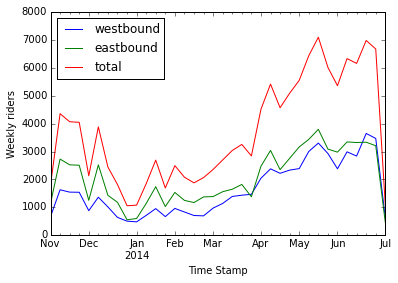

In [4]:
weekly[['westbound', 'eastbound', 'total']].plot()
plt.ylabel('Weekly riders');

The red line shows the total number of weekly crossings, which is the sum of the westbound and eastbound crossings.

At first glance, May and June 2014 include some spikes in the data: around 7,000 riders per week crossing this intersection. This trend might be a bit clearer if we use a **moving window average**: basically, for each day we'll take the average of the 30-day period around it:

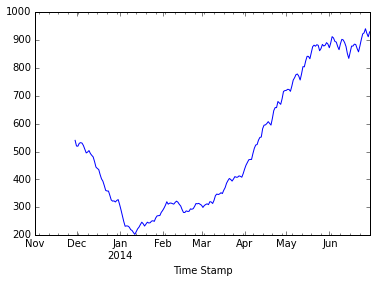

In [5]:
pd.stats.moments.rolling_mean(daily['total'], 30).plot();

Due to the short time range of the available data, we cannot see multiple years; however, we do see some seasonal variation.

What we're going to try to do below is to **model this variation** based on our intuition about what factors might come into play in people's decision about whether to ride.

For simplicity, I'm going to stick with a **linear model** here. It would be possible to go deeper and use a more sophisticated model, but a linear model should give us a good approximation of what's happening.

## Step 1: Accounting for hours of daylight

The largest component of the variation we see is a seasonal swing. Following Jake's hypothesis that that swings in ridership are at least partially due to the changing daylight hours, we compute the number of hours of daylight and use this to de-trend the data.

Borrowing the function from Jake's code:

In [6]:
# Define a function which returns the hours of daylight
# given the day of the year, from 0 to 365

def hours_of_daylight(date, axis=23.44, latitude=42.37):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

# add this to our weekly data
weekly['daylight'] = map(hours_of_daylight, weekly.index)
daily['daylight'] = map(hours_of_daylight, daily.index)

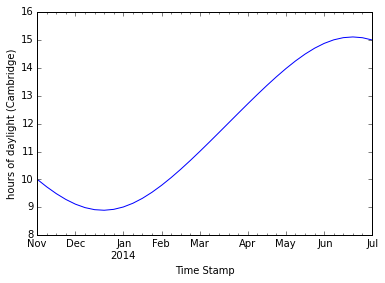

In [7]:
# Plot the daylight curve

weekly['daylight'].plot()
plt.ylabel('hours of daylight (Cambridge)');

This looks reasonable: around 9 hours of daylight in December, and around 15 hours in June.

To get a feel for the trend, let's plot the daylight hours versus the weekly bicycle traffic:

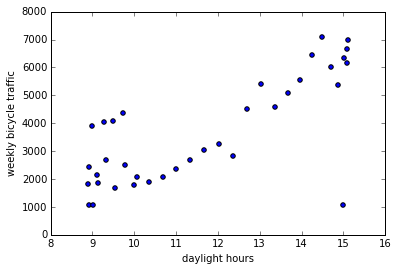

In [8]:
plt.scatter(weekly['daylight'], weekly['total'])
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

We see a clear trend, though it's also apparent from the vertical scatter that other effects are at play.

Let's apply a linear fit to this data. Basically, we'll draw a best-fit line to the points using some convenient tools in the [scikit-learn](http://scikit-learn.org) package:

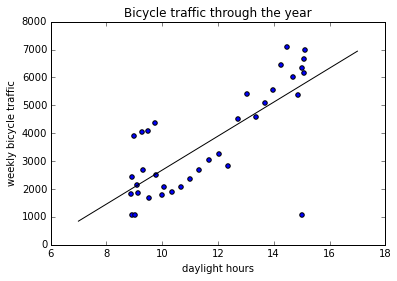

In [9]:
from sklearn.linear_model import LinearRegression

X = weekly[['daylight']].to_dense()
y = weekly['total']
clf = LinearRegression(fit_intercept=True).fit(X, y)

weekly['daylight_trend'] = clf.predict(X)
weekly['daylight_corrected_total'] = weekly['total'] - weekly['daylight_trend'] + weekly['daylight_trend'].mean()

xfit = np.linspace(7, 17)
yfit = clf.predict(xfit[:, None])
plt.scatter(weekly['daylight'], weekly['total'])
plt.plot(xfit, yfit, '-k')
plt.title("Bicycle traffic through the year")
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

In [10]:
print(clf.coef_[0])

609.341741376


This tells us that according to this model, each extra hour of daylight leads to about 600 more riders per week at this intersection! Of course, in Cambridge the length of the day also correlates highly with temperature and snow!?; we'll try to untangle those effects later.

Now that we have fit this trend, let's subtract it off and replace it by the mean:

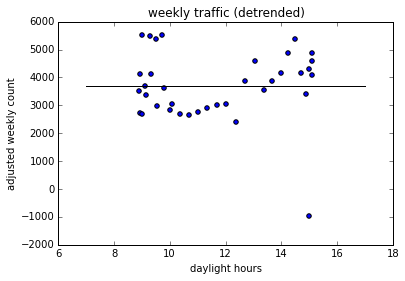

In [11]:
trend = clf.predict(weekly[['daylight']].as_matrix())
plt.scatter(weekly['daylight'], weekly['total'] - trend + np.mean(trend))
plt.plot(xfit, np.mean(trend) + 0 * yfit, '-k')
plt.title("weekly traffic (detrended)")
plt.xlabel('daylight hours')
plt.ylabel('adjusted weekly count');

This is the "de-trended" data. We've basically removed the component of the data which correlates with the number of hours in a day, so that what is left is in some way agnostic to this quantity. The "adjusted weekly count" plotted here can be thought of as the number of cyclists we'd expect to see if the hours of daylight were not a factor.

Note: there is an extreme outlier point on the bottom right of the plot. This is due to an incomplete week of data being recorded. Let's drop this record. 

Let's visualize this another way. Instead of plotting the number of riders vs daylight hours, we'll again plot the number of riders vs the day of the year, along with the trend:

In [12]:
# Remove last week (incomplete)
weekly = weekly[weekly.index <>'2014-07-06']

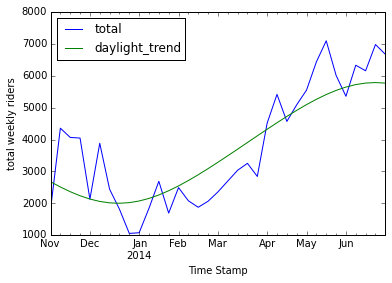

In [13]:
weekly[['total', 'daylight_trend']].plot()
plt.ylabel("total weekly riders");

We can similarly view the adjusted total number of riders over time by subtracting this green line from the blue line:

root-mean-square about trend: 938 riders


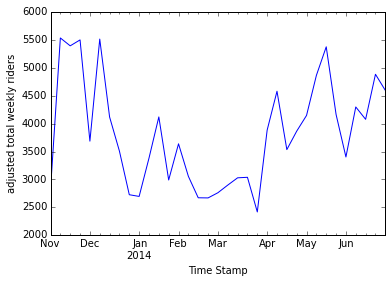

In [14]:
weekly['daylight_corrected_total'].plot()
rms = np.std(weekly['daylight_corrected_total'])
plt.ylabel("adjusted total weekly riders")
print("root-mean-square about trend: {0:.0f} riders".format(rms))

With the data de-trended, we get a better idea of how bicycling in Cambridge has changed over time, corrected for the seasonal variation. Even though we have de-trended the data, there still appears to be some variation related to the winter months that is not accounted for by the daylight hours. 

## Step 2: Accounting for Day of the Week

Above we've been looking at weekly data. This is because daily data shows a clear swing as a function of the day of the week, which we'll show here.

In [15]:
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
daily['dayofweek'] = daily['total'].index.dayofweek

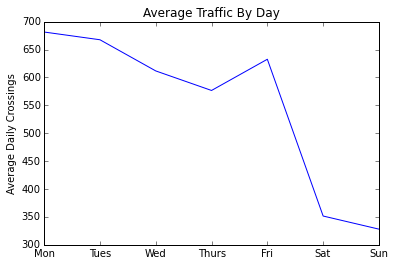

In [16]:
grouped = daily.groupby('dayofweek')['total'].mean()
grouped.index = days

grouped.plot()
plt.title("Average Traffic By Day")
plt.ylabel("Average Daily Crossings");

As you might expect in a city of bicycle commuters, there is roughly 2 times the amount of traffic on weekdays as there is on weekends. Bicycles are not just for entertainment! In Cambridge like in Seattle, they are a real means of commuting for and the data show this clearly. In contrast to Seattlites, Cambridge folk seem to like to bike on Fridays, but not Thursdays.

Let's de-trend the daily bike counts based on the daily totals. We'll add a variable for each day of the week, and use each of these within the trend (this is an example of what's sometimes known as "one-hot" encoding).

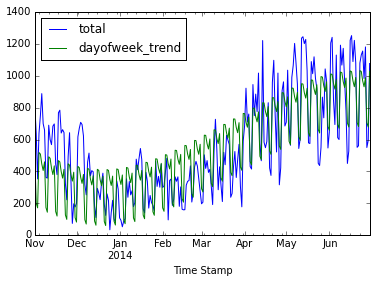

In [17]:
# Add one-hot indicators of weekday
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

# de-trend on days of the week and daylight together
X = daily[days + ['daylight']]
y = daily['total']
clf = LinearRegression().fit(X, y)

daily['dayofweek_trend'] = clf.predict(X)
daily[['total', 'dayofweek_trend']].plot();

This shows all the daily bicycle counts (in blue) along with the best-fit trend based on the day of the week and the number of daylight hours per day. It's more clear if we plot the de-trended data:

rms = 176


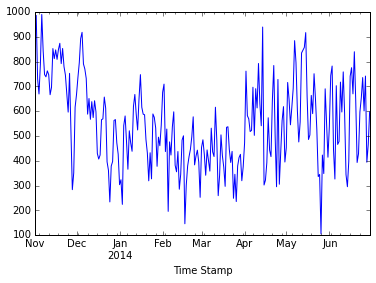

In [18]:
daily['dayofweek_corrected'] = (daily['total'] - daily['dayofweek_trend'] + daily['dayofweek_trend'].mean())
print("rms = {0:.0f}".format(np.std(daily['dayofweek_corrected'])))
daily['dayofweek_corrected'].plot();

Now we're getting somewhere! What we're seeing here is the number of bicycle crossings per day, corrected for the daily and annual trends.  In other words, this is what we might expect the data to look like if the day of the week and the hours of light per day did not matter.

Let's continue on this line of reasoning, and add some more information to the model.

## Step 3: Accounting for Temperature and Precipitation

Next we'll account for the NCDC climate data that was described above.  The data includes the daily maximum and minimum temperatures, as well as the amount of recorded rainfall and snowfall at Boston Logan airport, about 4 miles to the east. Let's take a look at this data:

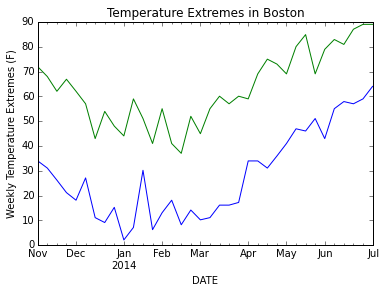

In [19]:
# Read the weather file
weather = pd.read_csv('BostonLoganWeather.csv', index_col='DATE', parse_dates=True, usecols=[2, 3, 5, 6, 7, 8])

# Replace missing values recorded as -9999 with 0
weather = weather.replace(-9999, 0)

# temperatures are in 1/10 deg C; convert to F
weather['TMIN'] = 0.18 * weather['TMIN'] + 32
weather['TMAX'] = 0.18 * weather['TMAX'] + 32

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254

# snow is in mm; convert to inches
weather['SNOW'] /= 25.4

# average wind speed is in 1/10 meters/sec; convert to miles/hour
weather['AWND'] /= 4.4704

weather['TMIN'].resample('w', 'min').plot()
weather['TMAX'].resample('w', 'max').plot()
plt.ylabel('Weekly Temperature Extremes (F)');
plt.title("Temperature Extremes in Boston");

This shows the maximum and minimum temperatures in Boston. They vary in ways you might expect. Winter lows are cold! (almost 0 around the end of the 2013)

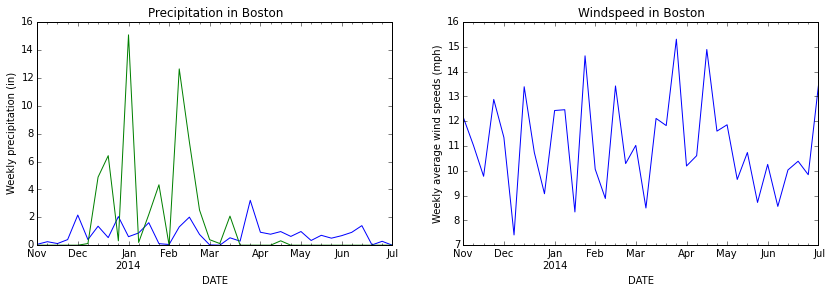

In [20]:
plt.figure(figsize=(14,4))

ax1 = plt.subplot(121)
weather['PRCP'].resample('w', 'sum').plot();
weather['SNOW'].resample('w', 'sum').plot();
plt.ylabel('Weekly precipitation (in)')
plt.title("Precipitation in Boston");

ax2 = plt.subplot(122)
weather['AWND'].resample('w', 'mean').plot();
plt.ylabel('Weekly average wind speeds (mph)')
plt.title("Windspeed in Boston");

The precipitation (shown in blue) is pretty evenly distributed throughout the year with some spikes, one particularly visible in the spring. Snowfall (shown in green) is present as expected in the winter months. 

What we do next will start to look very familiar: we'll add the climate information to our original daily dataset, and then use a linear model to de-trend the data with this new information.

In [21]:
# join the weather data to our daily data
daily = daily.join(weather)

This shows the data along with the overall trend, accounting for precipitation and temperature extremes. Let's de-trend the data with this model and see what's left over:

## Step 4: Accounting for Bike to Work Day and Nonlinear Effects of Temperature

Finally, there are some additional factors that may influence the number of bikers. As suggested in Jake's post, things like weather conditions yesterday (in addition to today) and nonlinear effects in temperature would be interesting to explore. We could also look at holidays. Here, we would like to account for Bike to Work Day on May 12, 2014 and nonlinear temperature effects. We expect more riders on Bike to Work Day and fewer riders when temperatures are extremely cold. 

In [22]:
# Create indicator flag for 5/12/2014
daily['bikeday'] = (daily.index == '2014-05-12').astype(int)

# Create nonlinear terms for temperature
daily['TMIN2'] = daily['TMIN']**2
daily['TMAX2'] = daily['TMAX']**2

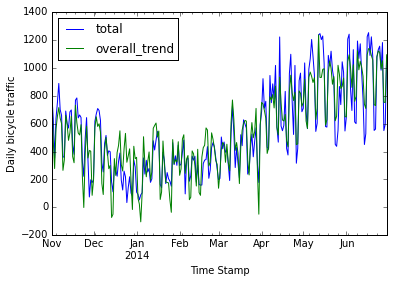

In [23]:
columns = days + ['daylight', 'TMIN', 'TMAX', 'TMIN2', 'TMAX2'
                  , 'PRCP', 'SNOW', 'AWND', 'bikeday']

X = daily[columns]
y = daily['total']
clf = LinearRegression().fit(X, y)
daily['overall_trend'] = clf.predict(X)

# Plot the overall trend
daily[['total', 'overall_trend']].plot()
plt.ylabel('Daily bicycle traffic');

This shows the data along with the overall trend, accounting for precipitation and temperature extremes. Let's de-trend the data with this model and see what's left over:

rms = 123


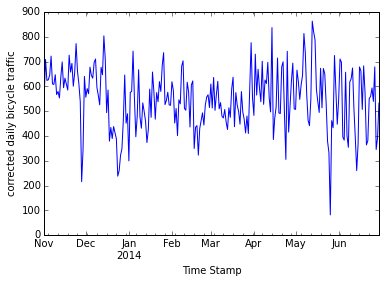

In [24]:
daily['overall_corrected'] = daily['total'] - daily['overall_trend'] + daily['overall_trend'].mean()
print("rms = {0:.0f}".format(np.std(daily['overall_corrected'])))
daily['overall_corrected'].plot()
plt.ylabel('corrected daily bicycle traffic');

From the reduced RMS (176 to 121), we can see that our model does a fairly good job capturing the trends. But there's still some daily variation that it cannot account for. We could think about what this might be, and try to capture it with more inputs to the model. For example, a person's choice to ride might be affected not just by the weather today, but by the weather yesterday. We also could account for freezing temperatures, which may manifest as a nonlinear effect.

In order to better see the remaining trend, let's plot a month-long moving-window average over the corrected data:

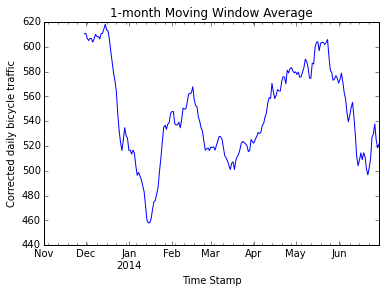

In [25]:
pd.stats.moments.rolling_mean(daily['overall_corrected'], 30).plot()
plt.ylabel('Corrected daily bicycle traffic')
plt.title('1-month Moving Window Average');

This is similar to the moving window we used above, except we are using de-trended data. What we see is that even after correcting for the length of day, the temperature, the precipitation (rainfall and snowfall), the wind, and the weekly trends, we still see what appear to be seasonal trends - lower than expected ridership in mid-January 2014 and higher than expected ridership in May 2014. 

One remark that is important to keep in mind: the detrended data hits a low-point in January 2014. This does not mean there were fewer riders in that month, but that there were **fewer riders than the model would expect** given the weather, hours of daylight, and day of the week. This points to the existence of other factors that we've not taken into account. Perhaps the average weather in a given time period affects people's decisions: that is, a warm day in January brings everyone out, while a warm day in July is so unexceptional that people leave their bike in the garage. It would be interesting to do a more detailed analysis and try to eke-out this type of information.

## What Can The Final Model Tell Us? 

Now that we have this model, we can use it to answer some questions about bike ridership in Cambridge.

First we'll convert the dependent variable (ridership) into log terms to make the results easier to interpret: one more inch of rain means X% drop in ridership.

In [26]:
# Calculate log of total rides per day
daily['log_total'] = np.log(daily['total'])

# Calculate the log model
X = daily[columns]
y = daily['log_total']

Next we'll fit the linear model and compute the error covariance, which contains the error bars on each of the parameters:

In [27]:
final_model = LinearRegression().fit(X, y)
daily['final_trend'] = final_model.predict(X)
#daily['final_corrected'] = daily['total'] - daily['final_trend'] + daily['final_trend'].mean()

vy = np.sum((y - daily['final_trend']) ** 2) / len(y)
X2 = np.hstack([X, np.ones((X.shape[0], 1))])
C = vy * np.linalg.inv(np.dot(X2.T, X2))
var = C.diagonal()

In [28]:
# Using statsmodels, report all results together in one table

# Create term for intercept and drop Wed (this will be the baseline)
X['ones'] = 1
X.drop('Wed', axis=1, inplace=True)

results = sm.OLS(y,X).fit()
print results.summary()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                            OLS Regression Results                            
Dep. Variable:              log_total   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     62.12
Date:                Thu, 19 Nov 2015   Prob (F-statistic):           2.41e-71
Time:                        15:53:08   Log-Likelihood:                -52.016
No. Observations:                 242   AIC:                             136.0
Df Residuals:                     226   BIC:                             191.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Mon            0.0590      0.077      0.768      0.4

We will take a closer look at each factor but for now, you can interpret as follows: each coef for day of week represents some arbitrary baseline level of ridership (arbitrary because we are in log space). The coeff for the other variables reflect percent increase in ridership. For example, one more hour of daylight has a coefficient of 0.0951 meaning that **one more hour of daylight translates to a 9% increase in cyclists**. The P>|t| value is the p-value. We can be sure of our prediction at the 95% confidence interval if the p-value is < 0.050.

### How Does Day of the Week Affect Ridership?

Our model shows that compared to Wednesday as the baseline, there are on average:**
- 6% more cyclists on a Monday
- 16% more cyclists on a Tuesday
- 6% less cyclists on a Thursday
- 3% less cyclists on a Friday
- 63% less cyclists on a Saturday
- 71% less cyclists on a Sunday**

This seems to coincide with the findings from Seattle where cycling is not just for fun, it's used for commuting! These results should be taken with a grain of salt due to varied significance; however, the drop in weekend cyclists is robust. 

### How Does Rain Affect Ridership?

In [29]:
ind = columns.index('PRCP')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.0f}% +/- {1:.0f}% daily crossings lost per inch of rain".format(-slope*100, error*100))

36% +/- 8% daily crossings lost per inch of rain


Our model shows that once all other factors are accounted for, **every inch of rain translates, on average, to a 36% decrease in cyclists**. Not a surprising result, but it's interesting to see it quantified!

### How Does Snow Affect Ridership?

In [30]:
ind = columns.index('SNOW')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.0f}% +/- {1:.0f}% daily crossings lost per inch of snow".format(-slope*100, error*100))

5% +/- 2% daily crossings lost per inch of snow


Our model shows that once all other factors are accounted for, **every inch of snow translates, on average, to a 5% decrease in cyclists**. Not a huge effect, but snow removal is pretty good in Boston so we might expect that people decide whether or not to bike more based on temperature rather than snowfall. 

### How Does Temperature Affect Ridership?

For temperature, we have to be more careful. The minimum and maximum temperature will be highly correlated, so we should average the trends between the two:

In [31]:
ind1, ind2 = columns.index('TMIN'), columns.index('TMAX')
slope = final_model.coef_[ind1] + final_model.coef_[ind2]
error = np.sqrt(var[ind1] + var[ind2])
print('{0:.0f}% +/- {1:.0f}% riders per ten degrees Fahrenheit'.format(10 * slope * 100, 10 * error * 100))

55% +/- 17% riders per ten degrees Fahrenheit


We see that for **every increase of ten degrees translates, on average, to a 55% increase in cyclists.**

Warmer is not always better. There do seem to be **diminishing returns to warmer temperatures**. Imagine change from 50-60 degrees, GOOD. Change from 70-80 degrees, still good but less good. 

### How Does Wind Affect Ridership?

In [32]:
ind = columns.index('AWND')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.0f}% +/- {1:.0f}% daily crossings lost per mph increase in average daily wind speeds".format(-slope*100, error*100))

1% +/- 1% daily crossings lost per mph increase in average daily wind speeds


As expected, the impact of wind speeds appears to be minimal.

### How Does Bike to Work Day Affect Ridership? 

In [33]:
ind = columns.index('bikeday')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.0f}% +/- {1:.0f}% daily crossings on Bike to Work Day".format(slope*100, error*100))

16% +/- 32% daily crossings on Bike to Work Day


While we are not very sure of this conclusion due to only having one Bike to Work day historically to evaluate, it seems that **Bike to Work Day increases ridership by 16%** accounting for other factors. 

## Conclusion

**Is Cambridge really less sensitive to the cold and more sensitive to the rain than Seattle? ** Let's compare the results of this analysis to the analysis of Seattle cycling. 